In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression

dataset = pd.read_csv("baseball_salary.csv")

# datasetから打点と推定年俸の配列をnumpy arrayとして取り出す

points = np.array(dataset["打点"])
salary = np.array(dataset["推定年俸"])

対数線形モデル


In [2]:
logsalary = np.log10(salary)

In [3]:
loglinear = LinearRegression().fit(points.reshape((-1,1)), logsalary.reshape((-1, 1)))
a = loglinear.coef_[0,0]
b = loglinear.intercept_[0]

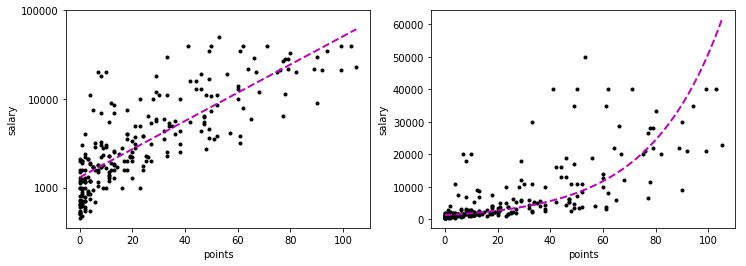

In [6]:
fig, axes = plt.subplots(1,2,sharex=True)
fig.set_size_inches(12, 4)

pvalues = np.linspace(points.min(), points.max(), 100)
def _calc(p):
    return a*p + b

# logsalary vs loglinear
axes[0].plot(points, logsalary, 'k.')
axes[0].plot(pvalues, _calc(pvalues), 'm--', lw=2)
axes[0].set_yticks((3,4,5))
axes[0].set_yticklabels((1000, 10000, 100000))

# salary vs loglinear
axes[1].plot(points, salary, 'k.')
axes[1].plot(pvalues, np.power(10, _calc(pvalues)), 'm--', lw=2)

for ax in axes:
    ax.set_xlabel("points")
    ax.set_ylabel("salary")
fig.savefig("images/loglinear_output.png")
plt.show()

## 非線形モデル

In [7]:
# 打点0の場合に対数にしようとするとエラーになるのを回避するための処置
logpoints = np.log10(points+1)

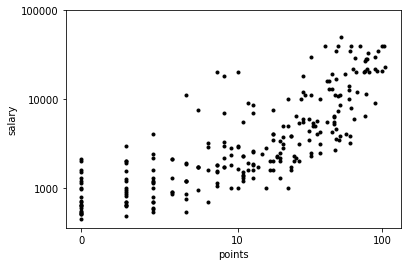

In [8]:
# 2つの特徴量をプロット
plt.figure()
plt.plot(logpoints, logsalary, 'k.')
plt.xticks((0, math.log10(11), math.log10(101)), (0, 10, 100))
plt.yticks((3, 4, 5), (1000, 10000, 100000))
plt.xlabel("points")
plt.ylabel("salary")
plt.show()

In [9]:
def nonlinear(x, logpoints=logpoints):
    a,b,H = x
    ret = np.empty(logpoints.size, dtype=float)
    above = logpoints > H
    below = ~above
    ret[below] = b
    ret[above] = a*(logpoints[above] - H) + b
    return ret

def residuals_nonlinear(x):
    return nonlinear(x) - logsalary

In [10]:
opt = least_squares(residuals_nonlinear, (0,0,0))
if opt['success'] == False:
    raise RuntimeError("estimation failed")
theta = opt['x']

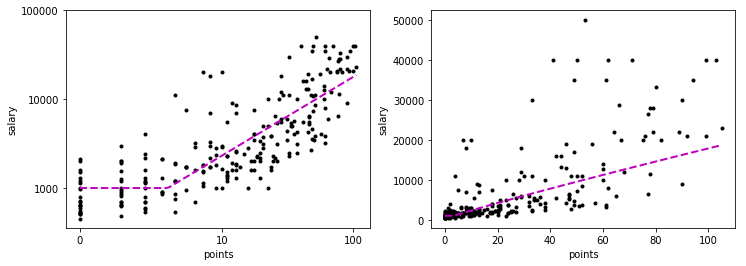

In [11]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12, 4)

logpvalues = np.linspace(logpoints.min(), logpoints.max(), 100)
pvalues = np.linspace(points.min(), points.max(), 100)
estimate = nonlinear(theta, logpoints=logpvalues)

# logsalary vs nonlinear
axes[0].plot(logpoints, logsalary, 'k.')
axes[0].plot(logpvalues, estimate, 'm--', lw=2)
axes[0].set_yticks((3,4,5))
axes[0].set_yticklabels((1000, 10000, 100000))
axes[0].set_xticks((0, math.log10(11), math.log10(101)))
axes[0].set_xticklabels((0, 10, 100))

# salary vs nonlinear
axes[1].plot(points, salary, 'k.')
axes[1].plot(pvalues, np.power(10, nonlinear(theta, logpoints=np.log10(pvalues+1))), 'm--', lw=2)

for ax in axes:
    ax.set_xlabel("points")
    ax.set_ylabel("salary")
fig.savefig("images/nonlinear_output.png")
plt.show()

交差検証


In [12]:
class BaseModel:
    def test(self, TP, TS, log=False):
        SS = (np.log10(self.estimate(TP)) - np.log10(TS))**2 if log==True else (self.estimate(TP) - TS)**2
        return np.nanmean(SS)

class LinearModel(BaseModel):
    def __init__(self, P, S):
        model = LinearRegression().fit(P.reshape((-1,1)), S.reshape((-1,1)))
        a = model.coef_[0,0]
        b = model.intercept_[0]
        self.params = (a, b)
    
    def estimate(self, TP):
        a, b = self.params
        return a*TP + b

class LogLinearModel(BaseModel):
    def __init__(self, P, S):
        logS  = np.log10(S)
        model = LinearRegression().fit(P.reshape((-1,1)), logS.reshape((-1,1)))
        a = model.coef_[0,0]
        b = model.intercept_[0]
        self.params = (a, b)
    
    def estimate(self, TP):
        a, b = self.params
        logS = a*TP + b
        return np.power(10, logS)

class NonLinearModel(BaseModel):
    def __init__(self, P, S):
        logP = np.log10(P+1)
        logS = np.log10(S)
        opt  = least_squares(self.residuals_nonlinear, (0,0,0), args=(logP, logS))
        if opt['success'] == False:
            raise RuntimeError("failed to estimate parameters")
        self.params = opt['x']
    
    def estimate(self, TP):
        return np.power(10, self.nonlinear(self.params, np.log10(TP+1)))
    
    def nonlinear(self, x, logP):
        a,b,H = x
        ret = np.empty(logP.size, dtype=float)
        above = logP > H
        below = ~above
        ret[below] = b
        ret[above] = a*(logP[above] - H) + b
        return ret
    
    def residuals_nonlinear(self, x, logP, logS):
        return self.nonlinear(x, logP) - logS

In [13]:
def run_cross_validation(P, S, *cls, k=10, logMSE=False):
    ntotal  = P.size
    ngroup  = ntotal // k
    indices = np.random.choice(np.arange(ntotal), size=ntotal, replace=False)
    borders = [ngroup*i for i in range(k)] + [None]
    results = np.empty((k, len(cls)), dtype=float); results[:] = np.nan
    
    for i, start, stop in zip(range(k), borders[:-1], borders[1:]):
        
        test = np.zeros(ntotal, dtype=bool)
        test[start:stop] = True
        itrain = indices[~test]
        itest  = indices[test]
        trainP = P[itrain]
        trainS = S[itrain]
        testP  = P[itest]
        testS  = S[itest]
        
        for j, mclass in enumerate(cls):
            results[i,j] = mclass(trainP, trainS).test(testP, testS, log=logMSE)
    return results

In [14]:
# k=10 で run_cross_validation を実行
np.random.seed(539167)
k = 10
results_MSE    = run_cross_validation(points, salary, LinearModel, LogLinearModel, NonLinearModel, k=k, logMSE=False)  # 浮動小数
results_logMSE = run_cross_validation(points, salary, LinearModel, LogLinearModel, NonLinearModel, k=k, logMSE=True) # 対数

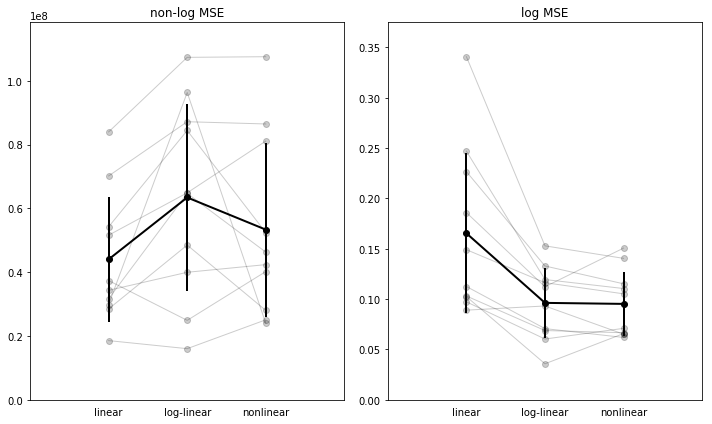

In [15]:
# グラフに描画
fig, axes = plt.subplots(1,2,sharex=True)
fig.set_size_inches(10, 6)
for ax, results, lab in zip(axes, (results_MSE, results_logMSE), ("non-log MSE", "log MSE")):
    ax.plot((0,1,2), results.T, 'o-', c='k', lw=1, alpha=0.2)
    m = np.nanmean(results, 0)
    s = np.nanstd(results, 0)
    ax.errorbar((0,1,2), m, fmt='ko-', yerr=s, lw=2)
    ax.tick_params(axis='both', bottom=False)
    ax.set_ylim(0, np.nanmax(results)*1.1)
    ax.set_title(lab)
axes[0].set_xlim(-1, 3)
axes[0].set_xticks((0,1,2))
axes[0].set_xticklabels(("linear", "log-linear", "nonlinear"))
plt.tight_layout()

In [16]:
# 各変数についてクロスバリデーションを実行
np.random.seed(539167)
logMSE = []
labels = []
for lab, col in (("points", "打点"),
                 ("batting_avg", "打率"),
                 ("years", "年数"),
                 ("weight", "体重"),
                 ("OPS", "OPS"),
                 ("RC27", "RC27"),
                 ("XR27", "XR27")):
    values = np.array(dataset[col])
    labels.append(lab)
    logMSE.append(run_cross_validation(values, salary, LogLinearModel, k=10, logMSE=True)[:,0])
logMSE = np.stack(logMSE, axis=-1)

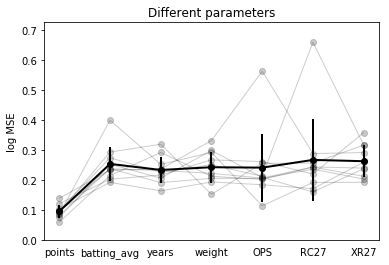

In [16]:
# グラフに描画
plt.figure()
x = np.arange(len(labels))
plt.plot(x, logMSE.T, 'o-', c='k', lw=1, alpha=0.2)
m = np.nanmean(logMSE, 0)
s = np.nanstd(logMSE, 0)
plt.errorbar(x, m, fmt='ko-', yerr=s, lw=2)
plt.ylim(0, np.nanmax(logMSE)*1.1)
plt.title("Different parameters")
plt.xticks(x, labels)
plt.ylabel("log MSE")
plt.tick_params(axis='both', bottom=False)

## 多重回帰

In [17]:
# データフレームからの抽出
points = np.array(dataset["打点"])
years  = np.array(dataset["年数"])

# データ形式の変更： N要素 (1次元) -> N行 x K列 (2次元)にする
# 2次元めのほうに「特徴量」軸がくるように、axis=-1を設定する
input_data = np.stack([points, years], axis=-1)

In [18]:
salary = np.array(dataset["推定年俸"])
output_data = np.log10(salary)

model = LinearRegression().fit(input_data, output_data)

In [19]:
# 係数の表示
model.coef_, model.intercept_

(array([0.01539671, 0.03432466]), 2.84531964884886)

In [20]:
# 1変数モデルのフィッティング
model1 = LinearRegression().fit(input_data[:,:1], output_data)

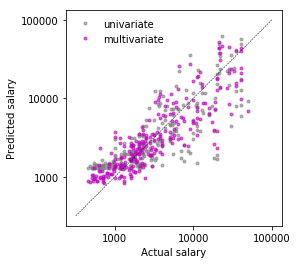

In [21]:
# input_dataおよびmodelは上で作成したもの
prediction1 = model1.predict(input_data[:,:1])
prediction2 = model.predict(input_data)

fig = plt.figure()
fig.set_size_inches(5, 5)

plt.plot(output_data, prediction1, '.', c='gray', alpha=.6, label='univariate')
plt.plot(output_data, prediction2, 'm.', alpha=.6, label='multivariate')

# グラフの見栄えをよくする
minvalue = 2.5 # 300万円
maxvalue = 5 # 10億円
plt.plot((minvalue, maxvalue), (minvalue, maxvalue), 'k--', lw=0.5)
plt.xlabel("Actual salary")
plt.ylabel("Predicted salary")

ticks = (3, 4, 5)
ticklabels = (1000, 10000, 100000)
plt.xticks(ticks, ticklabels)
plt.yticks(ticks, ticklabels)
plt.legend(frameon=False)
plt.subplots_adjust(left=.2, right=.8, bottom=.2, top=.8)
fig.savefig("images/multivariate_MSE.png")
plt.show()

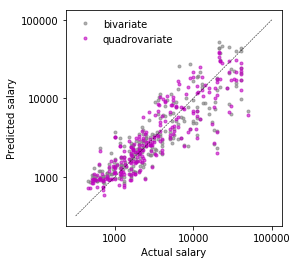

In [22]:
points = np.array(dataset["打点"])
years  = np.array(dataset["年数"])
turns  = np.array(dataset["打席数"])
onbase = np.array(dataset["出塁率"])

input_data = np.stack([points, years, turns, onbase], axis=-1)
model4 = LinearRegression().fit(input_data, output_data)
prediction4 = model4.predict(input_data)


fig = plt.figure()
fig.set_size_inches(5, 5)

plt.plot(output_data, prediction2, '.', c='gray', alpha=.6, label='bivariate')
plt.plot(output_data, prediction4, 'm.', alpha=.6, label='quadrovariate')

plt.plot((minvalue, maxvalue), (minvalue, maxvalue), 'k--', lw=0.5)
plt.xlabel("Actual salary")
plt.ylabel("Predicted salary")
ticks = (3, 4, 5)
ticklabels = (1000, 10000, 100000)
plt.xticks(ticks, ticklabels)
plt.yticks(ticks, ticklabels)
plt.legend(frameon=False)
plt.subplots_adjust(left=.2, right=.8, bottom=.2, top=.8)

## 多項式モデル

In [23]:
# データフレームからの抽出
points      = np.array(dataset["打点"])
salary      = np.array(dataset["推定年俸"])
output_data = np.log10(salary)

# pointsの2乗の項を、「別の入力変数」として追加する
input_data = np.stack([points, points**2], axis=-1)
model = LinearRegression().fit(input_data, output_data)

# 係数の表示
model.coef_, model.intercept_

(array([ 0.02517464, -0.0001164 ]), 3.0374872928206824)

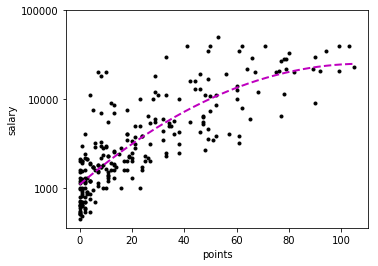

In [24]:
simulated_points = np.linspace(points.min(), points.max(), num=300)
predicted_salary = model.predict(np.stack([simulated_points, simulated_points**2], axis=-1))

fig = plt.figure()
plt.plot(points, output_data, 'k.')
plt.plot(simulated_points, predicted_salary, 'm--', lw=2)
plt.yticks((3,4,5), (1000, 10000, 100000))
plt.xlabel('points')
plt.ylabel('salary')
plt.subplots_adjust(left=0.2)
fig.savefig('images/binomial_model_plotted.png')
plt.show()

モデルの複雑さと過学習

In [25]:
# 8次までについて、10-交差検証をおこなう
M = 8 # 最大次数
K = 10 # 検証の数

bias_MSE    = np.empty((M,K),dtype=float) # 0軸にm次多項式モデルの結果、1軸にk番目の検証のMSE
vars_MSE    = np.empty((M,K),dtype=float)
input_data  = np.stack([points**m for m in range(1,M+1)], axis=-1) # 0軸が標本、1軸がm次の項
output_data = np.log10(salary)

np.random.seed(539167)
sample_size = input_data.shape[0]
choice      = np.random.choice(np.arange(sample_size), size=sample_size, replace=False)

samples_per_validation = sample_size // K

for k in range(K):
    start       = samples_per_validation * k
    stop        = samples_per_validation * (k+1)
    test_picked = choice[start:stop]
    train_mask  = np.ones(sample_size, dtype=bool); train_mask[test_picked] = False
    
    train_data  = input_data[train_mask,:]
    test_data   = input_data[~train_mask,:]
    train_ans   = output_data[train_mask]
    test_ans    = output_data[~train_mask]
    
    for m in range(1,M+1):
        model      = LinearRegression().fit(train_data[:,:m], train_ans)
        train_pred = model.predict(train_data[:,:m])
        test_pred  = model.predict(test_data[:,:m])
        
        bias_MSE[m-1,k] = ((train_pred - train_ans)**2).mean()
        vars_MSE[m-1,k] = ((test_pred - test_ans)**2).mean()

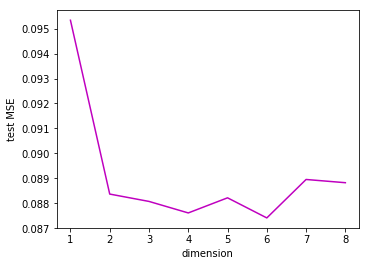

In [26]:
dims = np.arange(1,M+1)
fig = plt.figure()
plt.plot(dims, vars_MSE.mean(-1), 'm-')
plt.xlabel("dimension")
plt.ylabel("test MSE")
plt.subplots_adjust(left=0.2)
fig.savefig("images/polynomial_variances.png")
plt.show()

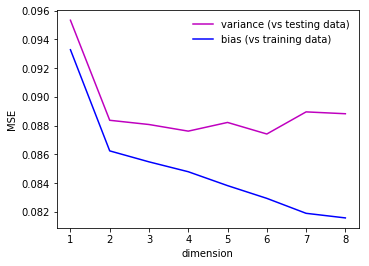

In [27]:
fig = plt.figure()
plt.plot(dims, vars_MSE.mean(-1), 'm-', label='variance (vs testing data)')
plt.plot(dims, bias_MSE.mean(-1), 'b-', label='bias (vs training data)')
plt.xlabel("dimension")
plt.ylabel("MSE")
plt.legend(frameon=False)
plt.subplots_adjust(left=0.2)
fig.savefig("images/polynomial_bias_variance.png")
plt.show()